Martin Aaskov Karlsen  
Postdoc  
Ravnsbæk Group  
Aarhus University  
November 2023  

# Background-subtraction for STOE STADI P *operando* PXRD data

The STOE STADI P diffractometer at the Department of Chemistry, Aarhus 
University  is  
equipped with an Ag x-ray source and can be used for *operando* powder x-ray 
diffraction  
(PXRD).

Compared to synchrotron x-ray data, the STOE data suffer from a lower 
signal-to-noise ratio.  
This results in difficult background-subtraction, which however is a good idea, 
when one is to  
visualize the signal of interest.

To ease the background subtraction, one can try to bin the data. This means that
intensity  
values will be summed, and the $2\theta/Q$-values will be averaged. The payoff 
is that we get better  
counting statistics for the intensities, i.e., higher signal-to-noise ratio. 
The drawback is a lower  
$2\theta/Q$-resolution by a factor of *binsize*.

**NB**: for the background-subtraction to work, please only include files 
containing actual data,  
i.e., please leave out any frames only containing background.

The code in this iPython notebook will:
- plot experimental data and background.
- bin data with a user-defined *binsize* to improve signal-to-noise ratio.
- plot the binned data and background.
- save the binned data and background to `.txt` files.
- scale the binned background to the binned data.
- plot the scaled, binned data and background.
- subtract the scaled, binned background from the binned data.
- plot the background-subtracted, binned data (both as stack and overview 
plots)
- save the background-subtracted data to a `.txt` file.

Imports.

In [25]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import savgol_filter
from diffpy.utils.parsers.loaddata import loadData

Dictionary with plot settings.

In [26]:
D_PLOT = dict(dpi=600,
              fs_labels=20,
              fs_ticks=14,
              fs_legend=14,
              ylabel=r"$I\;[\mathrm{arb.\;u.}]$",
              cmap="viridis",
              )

Please state the label to use for the $x$-axis, i.e., $2\theta\;[\degree]$ or
$Q\;[\mathrm{\AA}^{-1}]$.

In [27]:
D_PLOT["xlabel"] = r"$2\theta\;[\degree]$"
# D_PLOT["xlabel"] = r"$Q\;[\mathrm{\AA8}^{-1}]$"
print(f"{80*'-'}\nxlabel: {D_PLOT['xlabel']}\n{80*'-'}")

--------------------------------------------------------------------------------
xlabel: $2\theta\;[\degree]$
--------------------------------------------------------------------------------


Collecting data and background files.

In [28]:
data_path, bkg_path = Path.cwd() / "data", Path.cwd() / "bkg"
for p in (data_path, bkg_path):
    if not p.exists():
        p.mkdir()
        s = f"A folder called '{p.name}' has been created.\nPlease put your "
        if p.name == "data":
            s += "data files "
        else:
            s += "background file "
        s += f"there and rerun the cell."
        sys.exit(f"\n{80*'-'}\n{s}\n{80*'-'}")
data_files, bkg_files = list(data_path.glob("*.*")), list(bkg_path.glob("*.*"))
for p, l in ((data_path, data_files), (bkg_path, bkg_files)):
    if len(l) == 0:
        s = f"No data files were found in the '{p.name}' folder.\n"
        s += f"Please put your "
        if p.name == "data":
            s += f"data files "
        else:
            s += f"background file "
        s += "there and rerun the cell."
        sys.exit(f"\n{80*'-'}\n{s}\n{80*'-'}")
print(f"{80*'-'}\nData and background files collected.\n\tnumber of data "
      f"files: {len(data_files)}\n\tbackground file: {bkg_files[0].name}"
      f"\n{80*'-'}")

--------------------------------------------------------------------------------
Data and background files collected.
	number of data files: 569
	background file: 20230419_JKV_Background_DANOISE_Li+sep+ECDMC.001.xy
--------------------------------------------------------------------------------


Loading data files.

In [29]:
print(f"{80*'-'}\nLoading data files...")
for i, file in enumerate(data_files):
    print(f"\t{i}\t{file.name}")
    data = loadData(file)
    x, y = data[:, 0], data[:, 1]
    if i == 0:
        array = y
    else:
        array = np.column_stack((array, y))
print(f"Done loading data files.\n{80*'-'}")

--------------------------------------------------------------------------------
Loading data files...
	0	20231026_CBE_reg2_pm1.001.xy
	1	20231026_CBE_reg2_pm1.002.xy
	2	20231026_CBE_reg2_pm1.003.xy
	3	20231026_CBE_reg2_pm1.004.xy
	4	20231026_CBE_reg2_pm1.005.xy
	5	20231026_CBE_reg2_pm1.006.xy
	6	20231026_CBE_reg2_pm1.007.xy
	7	20231026_CBE_reg2_pm1.008.xy
	8	20231026_CBE_reg2_pm1.009.xy
	9	20231026_CBE_reg2_pm1.010.xy
	10	20231026_CBE_reg2_pm1.011.xy
	11	20231026_CBE_reg2_pm1.012.xy
	12	20231026_CBE_reg2_pm1.013.xy
	13	20231026_CBE_reg2_pm1.014.xy
	14	20231026_CBE_reg2_pm1.015.xy
	15	20231026_CBE_reg2_pm1.016.xy
	16	20231026_CBE_reg2_pm1.017.xy
	17	20231026_CBE_reg2_pm1.018.xy
	18	20231026_CBE_reg2_pm1.019.xy
	19	20231026_CBE_reg2_pm1.020.xy
	20	20231026_CBE_reg2_pm1.021.xy
	21	20231026_CBE_reg2_pm1.022.xy
	22	20231026_CBE_reg2_pm1.023.xy
	23	20231026_CBE_reg2_pm1.024.xy
	24	20231026_CBE_reg2_pm1.025.xy
	25	20231026_CBE_reg2_pm1.026.xy
	26	20231026_CBE_reg2_pm1.027.xy
	27	20231026_CBE

	53	20231026_CBE_reg2_pm1.054.xy
	54	20231026_CBE_reg2_pm1.055.xy
	55	20231026_CBE_reg2_pm1.056.xy
	56	20231026_CBE_reg2_pm1.057.xy
	57	20231026_CBE_reg2_pm1.058.xy
	58	20231026_CBE_reg2_pm1.059.xy
	59	20231026_CBE_reg2_pm1.060.xy
	60	20231026_CBE_reg2_pm1.061.xy
	61	20231026_CBE_reg2_pm1.062.xy
	62	20231026_CBE_reg2_pm1.063.xy
	63	20231026_CBE_reg2_pm1.064.xy
	64	20231026_CBE_reg2_pm1.065.xy
	65	20231026_CBE_reg2_pm1.066.xy
	66	20231026_CBE_reg2_pm1.067.xy
	67	20231026_CBE_reg2_pm1.068.xy
	68	20231026_CBE_reg2_pm1.069.xy
	69	20231026_CBE_reg2_pm1.070.xy
	70	20231026_CBE_reg2_pm1.071.xy
	71	20231026_CBE_reg2_pm1.072.xy
	72	20231026_CBE_reg2_pm1.073.xy
	73	20231026_CBE_reg2_pm1.074.xy
	74	20231026_CBE_reg2_pm1.075.xy
	75	20231026_CBE_reg2_pm1.076.xy
	76	20231026_CBE_reg2_pm1.077.xy
	77	20231026_CBE_reg2_pm1.078.xy
	78	20231026_CBE_reg2_pm1.079.xy
	79	20231026_CBE_reg2_pm1.080.xy
	80	20231026_CBE_reg2_pm1.081.xy
	81	20231026_CBE_reg2_pm1.082.xy
	82	20231026_CBE_reg2_pm1.083.xy
	83	202310

Loading background data.

In [30]:
print(f"{80*'-'}\nLoading background file...\n\t{bkg_files[0].name}")
data_bkg = loadData(bkg_files[0])
x_bkg, y_bkg = data_bkg[:, 0], data_bkg[:, 1]
print(f"Done loading background data.\n{80*'-'}")

--------------------------------------------------------------------------------
Loading background file...
	20230419_JKV_Background_DANOISE_Li+sep+ECDMC.001.xy
Done loading background data.
--------------------------------------------------------------------------------


Plot function plotting intensity vs. $2\theta/Q$ for data and background.

In [31]:
def plot_stack(x, array, d, name, plot_paths, x_bkg=None, y_bkg=None):
    cmap = colormaps[d["cmap"]]
    colors = cmap(np.linspace(0, 1, array.shape[1]))
    fig, axs = plt.subplots(ncols=2, 
                            figsize=(12, 4),
                            gridspec_kw=dict(width_ratios=[1, 0.015]),
                            )
    for i in range(array.shape[1]):
        axs[0].plot(x, array[:, i], c=colors[i])
    if not isinstance(x_bkg, type(None)) and not isinstance(x_bkg, type(None)):
        axs[0].plot(x_bkg, y_bkg, c="k", label="bkg")
        axs[0].legend(framealpha=0, fontsize=d["fs_legend"])
    axs[0].set_xlim(np.amin(x), np.amax(x))
    axs[0].set_xlabel(d["xlabel"], fontsize=d["fs_labels"])
    axs[0].set_ylabel(d["ylabel"], fontsize=d["fs_labels"])
    axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    axs[0].tick_params(axis="both", labelsize=d["fs_ticks"])
    axs[0].minorticks_on()
    sm = plt.cm.ScalarMappable(cmap=cmap.reversed(),
                               norm=plt.Normalize(vmin=0, vmax=1),
                               )
    cbar = plt.colorbar(sm,
                        cax=axs[1],
                        ticks=[0, 1],
                        )
    cbar.ax.set_yticklabels(["end", "start"])
    cbar.ax.tick_params(axis="y")
    plt.subplots_adjust(wspace=0.05)   
    for p in plot_paths:
        print(f"\t{p.name}")
        plt.savefig(p / f"{name}.{p.name}", dpi=d["dpi"], bbox_inches="tight")
    plt.show()

    return None

Creating plot folders.

In [32]:
plot_folders = ["png", "pdf", "svg"]
plot_paths = [Path.cwd() / folder for folder in plot_folders]
for p in plot_paths:
    if not p.exists():
        p.mkdir()

Plotting data files and background.

--------------------------------------------------------------------------------
Plotting data files and background...
	png
	pdf
	svg


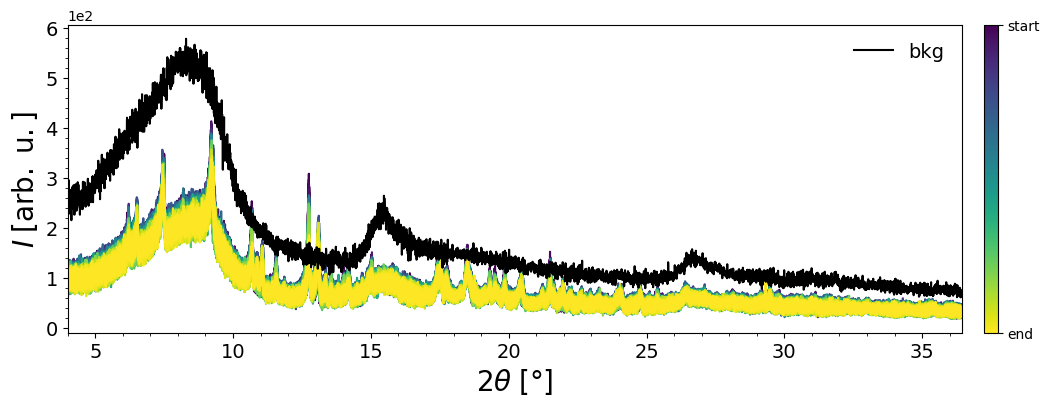

Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


In [33]:
print(f"{80*'-'}\nPlotting data files and background...")
plot_stack(x, array, D_PLOT, "stack_bkg_not_scaled", plot_paths, x_bkg, y_bkg)
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

Plot function for overview plot.

In [34]:
def plot_overview(x, array, d, name, plot_paths):
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(array, 
                   aspect="auto", 
                   vmin=0,
                   vmax=np.amax(array),
                   extent=(0, array.shape[1], np.amax(x), np.amin(x)),
                   )
    ax.set_xlabel("frame", fontsize=d["fs_labels"])
    ax.xaxis.set_label_position("top")
    ax.set_ylabel(d["xlabel"], fontsize=d["fs_labels"])
    ax.tick_params(axis="x",
                   which="both",
                   top=True,
                   bottom=False,
                   labeltop=True,
                   labelbottom=False,
                   )
    ax.tick_params(axis="both", labelsize=d["fs_ticks"])
    ax.minorticks_on()
    cbar = plt.colorbar(im)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.set_label(d["ylabel"], fontsize=d["fs_labels"])
    cbar.ax.tick_params(labelsize=d["fs_ticks"])
    for p in plot_paths:
        print(f"\t{p.name}")
        plt.savefig(p / f"{name}.{p.name}", bbox_inches="tight", dpi=d["dpi"])
    plt.show()

    return None

Overview plot of data prior to background-subtraction.

--------------------------------------------------------------------------------
Overview plot of data...
	png
	pdf
	svg


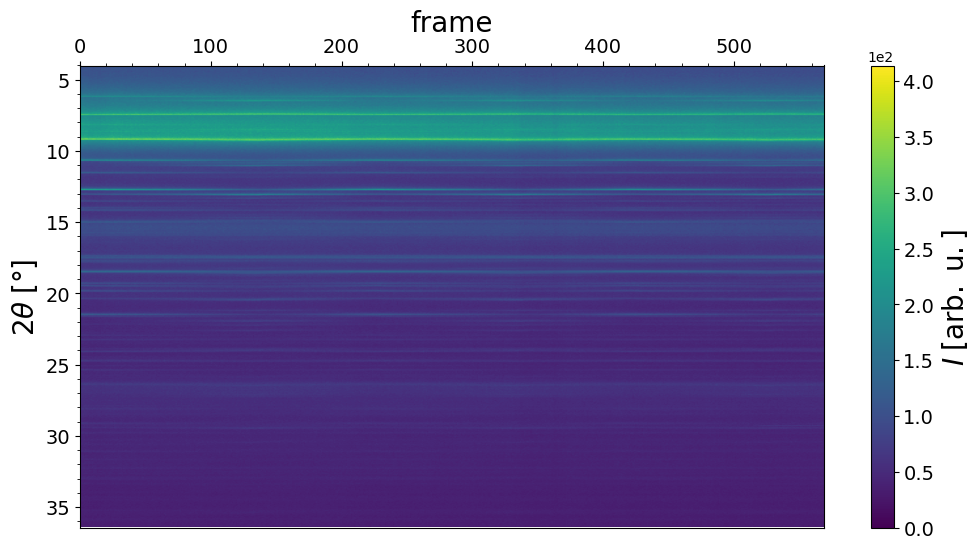

Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


In [35]:
print(f"{80*'-'}\nOverview plot of data...")
plot_overview(x, 
              array, 
              D_PLOT, 
              f"overview",
              plot_paths,
              )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

Function to bin data to improve counting statistics (signal-to-noise ratio).

In [36]:
def bin(x, y, binsize):
    x_bin, y_bin = [], []
    for i in range(round(len(x) / binsize)):
        if not i == len(y) - 1:
            x_bin.append(x[i*binsize:binsize*(i+1)].mean())
            y_bin.append(y[i*binsize:binsize*(i+1)].mean())
        else:
            x_bin.append(x[i*binsize:].mean())
            y_bin.append(y[i*binsize:].mean())
    
    return np.array(x_bin), np.array(y_bin)

Binning and plotting background data for various binsizes to arrive at a binsize to use for  
background and data.

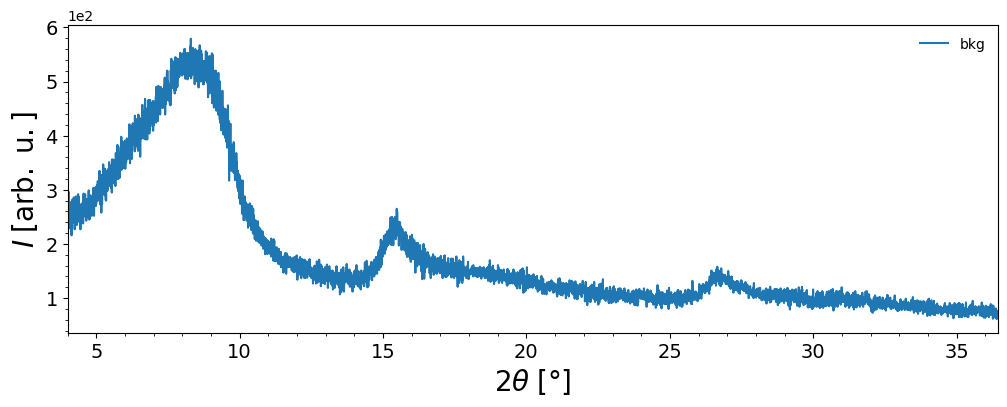

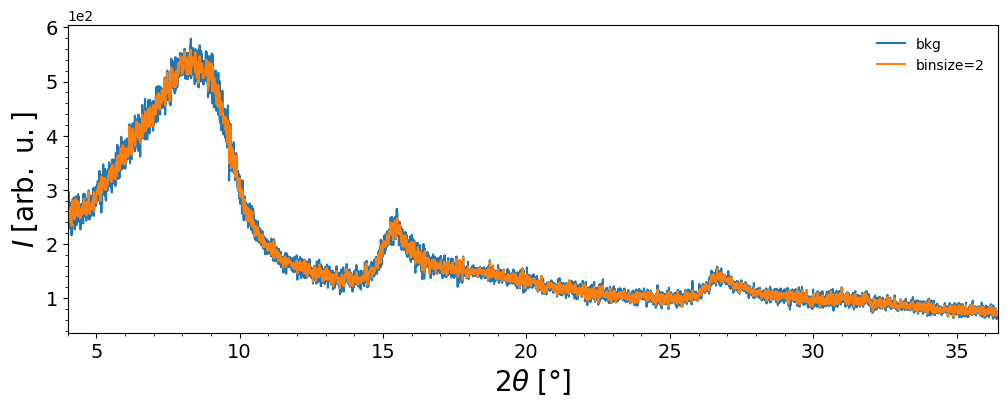

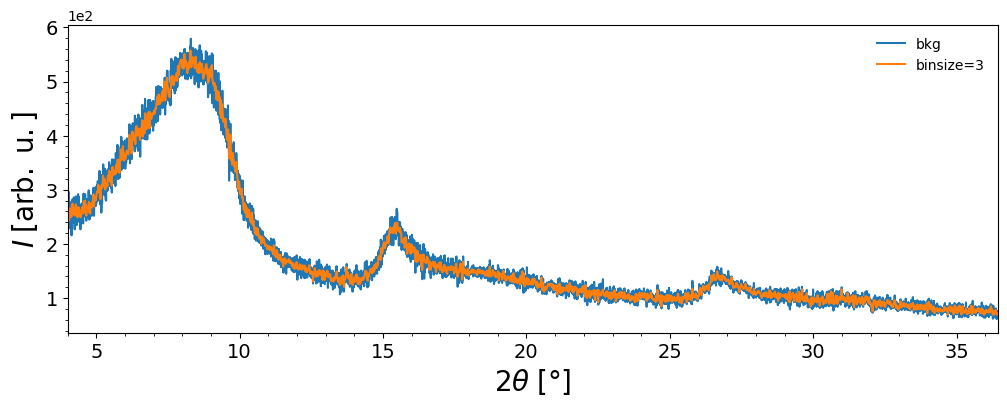

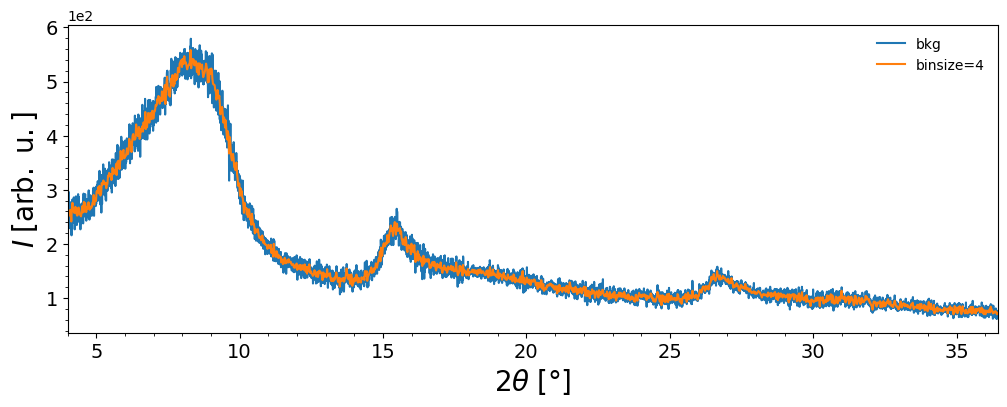

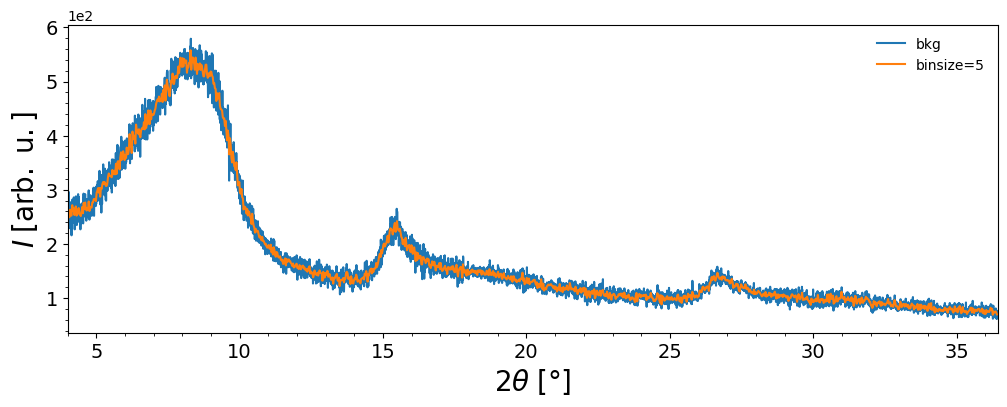

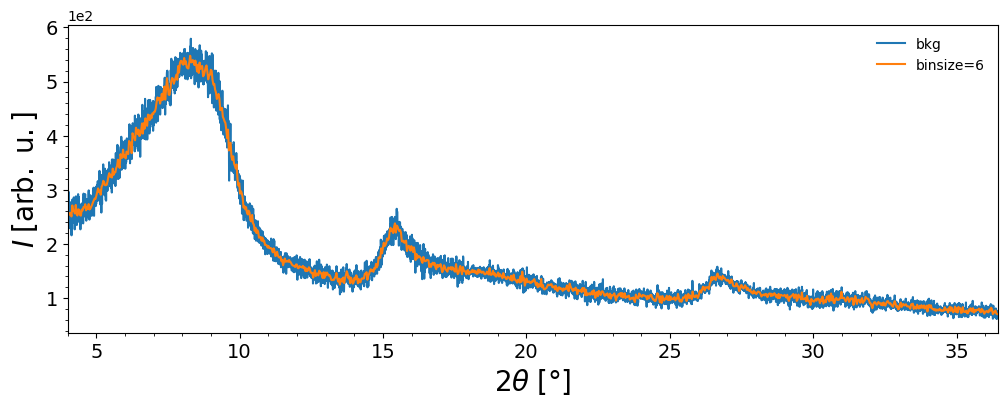

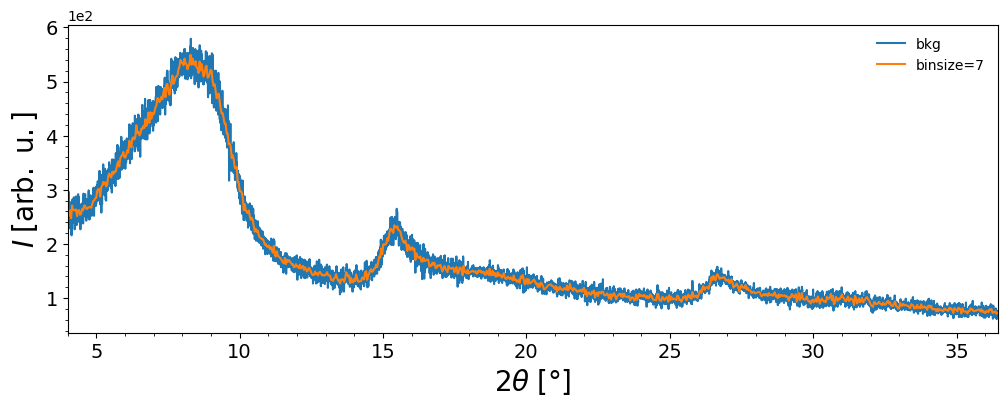

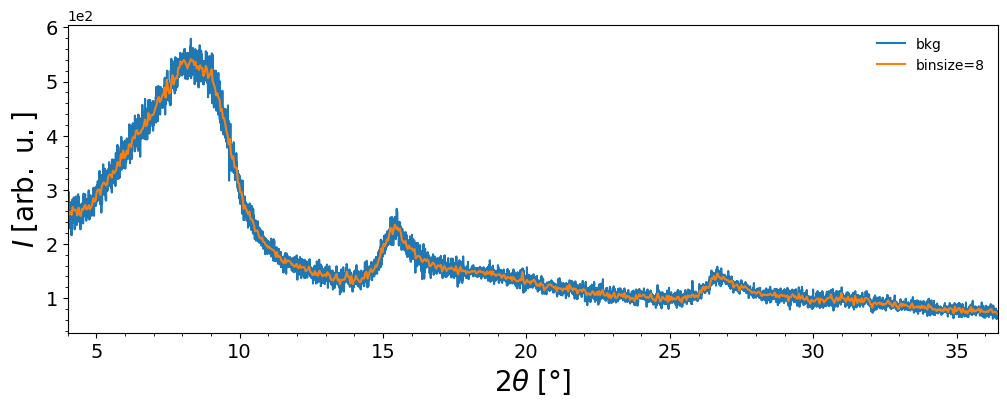

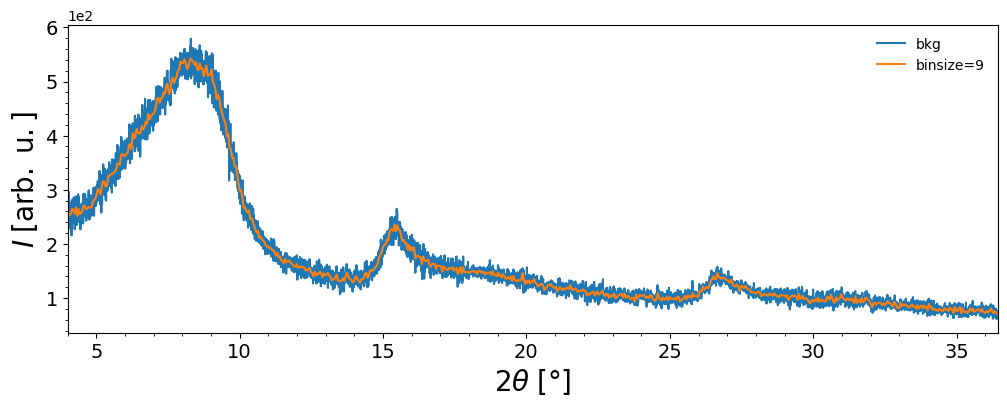

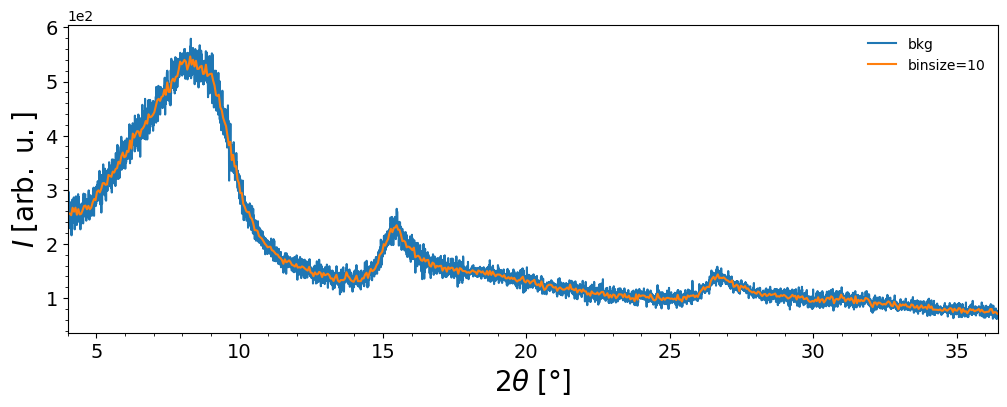

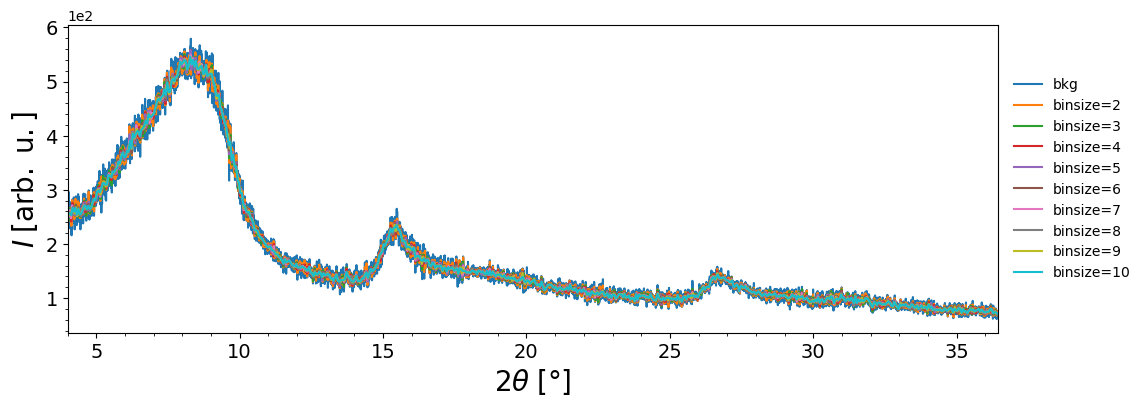

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_bkg, y_bkg, label="bkg")
ax.set_xlim(np.amin(x), np.amax(x))
ax.set_xlabel(r"$2\theta\;[\degree]$", fontsize=20)
ax.set_ylabel(r"$I\;[\mathrm{arb.\;u.}]$", fontsize=20)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.tick_params(axis="both", labelsize=14)
ax.legend(loc="upper right", framealpha=0)
ax.minorticks_on()
plt.show()

for i in range(2, 11):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_bkg, y_bkg, label="bkg")
    x_bin, y_bin = bin(x_bkg, y_bkg, binsize=i)
    ax.plot(x_bin, y_bin, label=f"binsize={i}")
    ax.set_xlim(np.amin(x), np.amax(x))
    ax.set_xlabel(r"$2\theta\;[\degree]$", fontsize=20)
    ax.set_ylabel(r"$I\;[\mathrm{arb.\;u.}]$", fontsize=20)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.tick_params(axis="both", labelsize=14)
    ax.minorticks_on()
    ax.legend(loc="upper right", framealpha=0)
    plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_bkg, y_bkg, label="bkg")
for i in range(2, 11):
    x_bin, y_bin = bin(x_bkg, y_bkg, binsize=i)
    ax.plot(x_bin, y_bin, label=f"binsize={i}")
    ax.set_xlim(np.amin(x), np.amax(x))
    ax.set_xlabel(r"$2\theta\;[\degree]$", fontsize=20)
    ax.set_ylabel(r"$I\;[\mathrm{arb.\;u.}]$", fontsize=20)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.tick_params(axis="both", labelsize=14)
    ax.minorticks_on()
ax.legend(loc="center right", borderaxespad=-10, framealpha=0)
plt.show()

Based on the plot above, state the binsize to use for background and data.

In [49]:
binsize = 5

Binning data and background.

In [50]:
print(f"{80*'-'}\nBinning data and background...\n\tbinsize: {binsize}")
array_bin = []
for i in range(array.shape[1]):
    if i == 0:
        x_bin, y_bin = bin(x, array[:, i], binsize)
    else:
        _, y_bin = bin(x, array[:, i], binsize)
    array_bin.append(y_bin)
array_bin = np.array(array_bin).T
x_bkg_bin, y_bkg_bin = bin(x_bkg, y_bkg, binsize)
print(f"Done.\n{80*'-'}")

--------------------------------------------------------------------------------
Binning data and background...
	binsize: 5
Done.
--------------------------------------------------------------------------------


Plotting binned data and background.

--------------------------------------------------------------------------------
Plotting binned data and background...
	png
	pdf
	svg


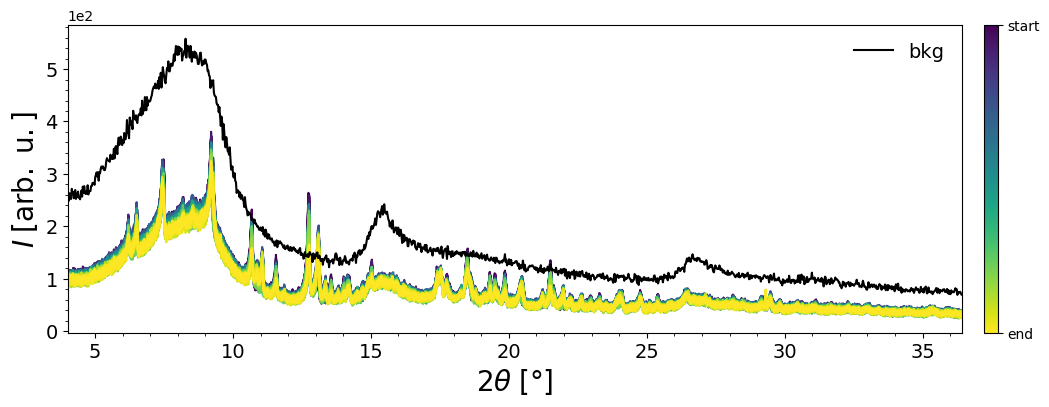

Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


In [51]:
print(f"{80*'-'}\nPlotting binned data and background...")
plot_stack(x_bin, 
           array_bin, 
           D_PLOT, 
           f"stack_bin_binsize={binsize}",
           plot_paths,
           x_bkg_bin,
           y_bkg_bin,
           )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

Writing binned data and background to files.

In [52]:
data_binned_path = Path.cwd() / "data_binned"
bkg_binned_path = Path.cwd() / "bkg_binned"
for p in (data_binned_path, bkg_binned_path):
    if not p.exists():
        p.mkdir()
print(f"{80*'-'}\nWriting denoised data and background to files...")
header = "x"
for i in range(array.shape[1]):
    header += f"\ty{i+1}"
np.savetxt(data_binned_path / f"data_binned_binsize={binsize}.txt",
           np.column_stack((x_bin, array_bin)),
           header=header,
           delimiter="\t",
           encoding="utf-8",
           )
np.savetxt(bkg_binned_path / f"bkg_binned_binsize={binsize}.txt",
           np.column_stack((x_bin, y_bkg_bin)),
           header="x\ty",
           delimiter="\t",
           encoding="utf-8",
           )
print(f"Done. Please see the '{data_binned_path.name}' and "
      f"'{bkg_binned_path.name}' folders.\n{80*'-'}")

--------------------------------------------------------------------------------
Writing denoised data and background to files...
Done. Please see the 'data_binned' and 'bkg_binned' folders.
--------------------------------------------------------------------------------


Function to obtain scale factor for background.

In [53]:
def bkg_scale(y, y_bkg):
    scale = 1
    for i in range(1, 11):
        if np.any((y - scale * y_bkg <= 0)):
            while np.any((y - scale * y_bkg <= 0)):
                scale -= 10**-i
            scale += 10**-i
        else:
            while not np.any((y - scale * y_bkg <= 0)):
                scale += 10**-i
            scale -= 10**-i
    return scale

Obtaining background scale factor for all frames and using the lowest value
encountered.  
This results in no negative intensities for background-subtracted data.

In [54]:
scale = np.amin(np.array([bkg_scale(array_bin[:, i], y_bkg_bin) 
                          for i in range(array_bin.shape[1])]))
print(f"{80*'-'}\nscale factor: {scale:.10f}\n{80*'-'}")

--------------------------------------------------------------------------------
scale factor: 0.2969588551
--------------------------------------------------------------------------------


Plotting data and scaled background.

--------------------------------------------------------------------------------
Plotting data and scaled background...
	png
	pdf
	svg


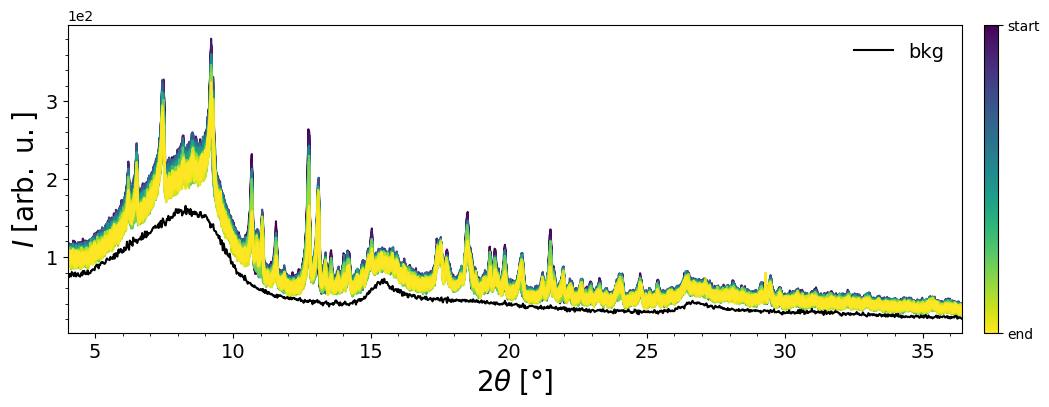

Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


In [55]:
print(f"{80*'-'}\nPlotting data and scaled background...")
plot_stack(x_bin, 
           array_bin, 
           D_PLOT, 
           f"stack_bin_binsize={binsize}_bkg-scaled",
           plot_paths,
           x_bkg_bin,
           y_bkg_bin * scale,
           )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

Subtracting background from data.

In [56]:
print(f"{80*'-'}\nSubtracting background from data...")
for i in range(array_bin.shape[1]):
    if i == 0:
        array_bin_bkgsub = array_bin[:, i] - scale * y_bkg_bin
    else:
        array_bin_bkgsub = np.column_stack((array_bin_bkgsub,
                                            array_bin[:, i] - scale * y_bkg_bin,
                                            ))
print(f"Done.\n{80*'-'}")

--------------------------------------------------------------------------------
Subtracting background from data...
Done.
--------------------------------------------------------------------------------


Plotting background-subtracted data.

--------------------------------------------------------------------------------
Plotting background-subtracted data...
	png
	pdf
	svg


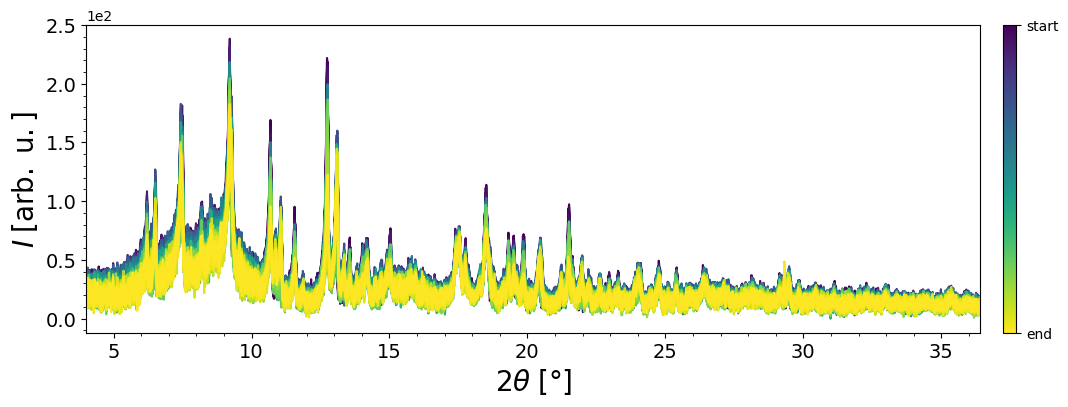

Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


In [57]:
print(f"{80*'-'}\nPlotting background-subtracted data...")
plot_stack(x_bin, 
           array_bin_bkgsub, 
           D_PLOT, 
           f"stack_bin_binsize={binsize}_bkgsub",
           plot_paths,
           )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

Writing background-subtracted data to file.

In [58]:
data_binned_bkgsub_path = Path.cwd() / "data_binned_bkgsub"
if not data_binned_bkgsub_path.exists():
    data_binned_bkgsub_path.mkdir()
print(f"{80*'-'}\nWriting binned, background-subtracted data to file...")
header = "x"
for i in range(array_bin_bkgsub.shape[1]):
    header += f"\ty{i+1}"
np.savetxt(data_binned_bkgsub_path / f"data_binned_bkgsub.txt",
           np.column_stack((x_bin, array_bin_bkgsub)),
           header=header,
           delimiter="\t",
           encoding="utf-8",
           )
print(f"Done. Please see the '{data_binned_bkgsub_path.name}' folder."
      f"\n{80*'-'}")

--------------------------------------------------------------------------------
Writing binned, background-subtracted data to file...
Done. Please see the 'data_binned_bkgsub' folder.
--------------------------------------------------------------------------------


Overview plot for background-subtracted data.

--------------------------------------------------------------------------------
Overview plot of background-subtracted data...
	png
	pdf
	svg


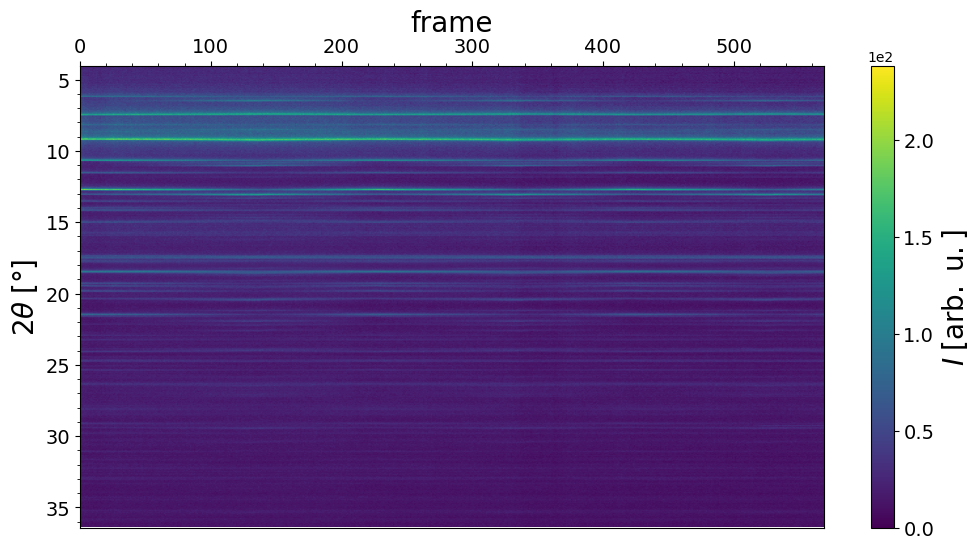

Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


In [59]:
print(f"{80*'-'}\nOverview plot of background-subtracted data...")
plot_overview(x_bin, 
              array_bin_bkgsub, 
              D_PLOT, 
              f"overview_bin_binsize={binsize}_background-subtracted",
              plot_paths,
              )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")